In [1]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
lemmatizer = WordNetLemmatizer()

#set random seed for the session
random.seed(1)
np.random.seed(1)

#load train data
train=pd.read_csv("train.tsv",sep='\t')
print(train.shape)
train.head()

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [2]:
#load test data
test=pd.read_csv("test.tsv",sep='\t')
print(test.shape)
test.head()

(66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [3]:
#method to clean the reviews, tokenize, remove stop words and lemmatize them.
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #stop words removal
        omit_words = set(stopwords.words('english'))
        words = [x for x in words if x not in omit_words]
        
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

#cleaned reviews for both train and test set retrieved
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(len(train_sentences))
print(len(test_sentences))

100%|███████████████████████████████████████████████████████████████████████████| 66292/66292 [03:15<00:00, 338.24it/s]

156060
66292


In [4]:
#collect the dependent values
target=train.Sentiment.values

In [5]:
# Set values for various parameters of word2vec
num_features = 250  # Word vector dimensionality. Determines the no of words each word in the vocabulary will
#be associated with. Must be tuned.
min_word_count = 50   # Minimum word count. Wods occuring below the threshold will be ignored
num_workers = 1       # Number of threads to run in parallel
context = 15          # Context window size to be considered for each word                                             
downsampling = 1e-3   # Downsample setting for frequent words. To prevent more frequent words from dominating.


In [7]:
from gensim.models import word2vec

#Model Word2Vec
model = word2vec.Word2Vec(train_sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If the model is not going to be trained further, init_sims can be called 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

In [8]:
#the word2vec builds associations for each word with other words in the vocabulary of the problem.
#the model can be used to test differnt word associations. similarities, etc. to know how good the model
#or the vocabulary is. In the example here, 4 words are given and the model chosses the dissimilar word amonsgt them.
#here it chooses length. Good Bad & Nice are adjectives to describe a movie, 'Length' is something.
#Hence the model has built this association.
print(model.wv.doesnt_match("length good bad nice".split()))

length


C:\Users\Mahesh-PC\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [9]:
# test the same condition with totally differnt word. The output is correctly 'red'.
print(model.wv.doesnt_match("fun good bad red".split()))

red


In [10]:
#print the three most common words
print(model.wv.index2word[0], model.wv.index2word[1], model.wv.index2word[2])

film movie n


In [11]:
#print the three least common words
total_words = len(model.wv.vocab)
print(model.wv.index2word[total_words - 1], model.wv.index2word[total_words - 2], model.wv.index2word[total_words - 3])

crack snipe pandering


In [12]:
#print the most similar words associated with 'actor'. The word 'role' and 'lead' appears at the top.
print(model.wv.most_similar("actor"))

[('role', 0.8104479908943176), ('lead', 0.7973312735557556), ('career', 0.7386322617530823), ('academy', 0.7338787317276001), ('niro', 0.7332068681716919), ('award', 0.7321874499320984), ('talented', 0.7235428094863892), ('de', 0.7228742241859436), ('talent', 0.7195686101913452), ('appear', 0.7186208367347717)]


In [13]:
def createFeatureVector(words, model, num_features):
    #initialize a 1D array with length as num of features of word2vec model chosen by us. 
    #Here it is 250.
    featVector = np.zeros((num_features,),dtype="float32")
    
    nWords = 0
    
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, as set is faster
    index2word_set = set(model.wv.index2word)
    
    # Loop over each word and add it to the feature vector to get the total sum of feature vectors of the
    #entire review
    for word in words:
        if word in index2word_set: 
            nWords = nWords + 1.
            featVector = np.add(featVector,model[word])
            
    # Divide the result by the number of words to get the average of the feature vectors of 
    #all words in the review
    if(nWords != 0):
        featVector = np.divide(featVector,nWords)
    return featVector

#calculates the average of the feature vectors for each review using the word2vec values assigned for 
#each word
def avgFeatureVectors(sentences, model, num_features):
    overallFeatureVectors = []
    for sentence in tqdm(sentences):
        overallFeatureVectors.append(createFeatureVector(sentence, model, num_features)) 
    return overallFeatureVectors

train_vect = avgFeatureVectors( train_sentences, model, num_features )
test_vect = avgFeatureVectors( test_sentences, model, num_features )

100%|██████████████████████████████████████████████████████████████████████████| 66292/66292 [00:38<00:00, 1720.46it/s]


In [14]:
#split into train and validation sets.
X_train,X_val,y_train,y_val=train_test_split(train_vect,target,test_size=0.2,stratify=target)

In [15]:
from sklearn.ensemble import RandomForestClassifier

#Model RF
model_rf = RandomForestClassifier(random_state=1, n_estimators=500, verbose=1, n_jobs=-1, oob_score=True)
model_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 34.8min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=1, verbose=1,
                       warm_start=False)

In [16]:
from sklearn.metrics import accuracy_score

#the score for the trained model. Here it is around 62%. It can be further increased, by fine-tuning
#word2vec model as well as rf model. The no of estimators for example can be increased to boost the accuracy.
#The score can definitely be improved further by fine tuning and possibly grid search.
result = model_rf.predict( X_val )
score = accuracy_score(y_val,result)
print(score)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    5.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   13.0s


0.6220363962578496


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   14.6s finished


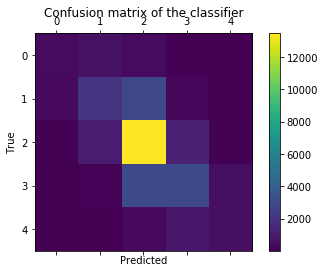

[[  404   587   387    33     3]
 [  361  2007  2851   226    10]
 [   91  1043 13469  1255    58]
 [   11   152  2968  2954   501]
 [    4    21   368   867   581]]


In [17]:
from sklearn.metrics import confusion_matrix

#visualizing the confusion matrix of the results. As expected the category of neutral ('2') is the best
# performing as more no of records in the dataset belong to this class. Other classes are little
#under-represented and hence not learnt well by the model. Over-sampling, Under-sampling or combination 
#of both can mitigate this problem to a degree. Also SMOTE can be tried to create synthetic samples for
#under-represented classes to balance the equation little bit. Class weights is also another option
# that can be used to tell the model to pay more attention to certain classes while training.

labels = [0,1,2,3,4]
conf = confusion_matrix(y_val,result,labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(conf)

#here 0 - negative, 1- somewhat negative, 2- neutral, 3- somewhat positive, 4- positive